# Generate the Jacobian for a full  

In [1]:
from jax import jit, vjp, vmap, pmap, debug
import jax
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt


from jwave.geometry import Domain, Medium
from jwave.utils import display_complex_field

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field, generate_2D_gridded_src_rec_positions
from hybridoed.oed import *

# Confirm JAX device
print(jax.devices())

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11)]


In [2]:
from jwave.acoustics.time_harmonic import helmholtz, helmholtz_solver

def solve_helmholtz_general(sound_speed, src_coord, omega):
    # Ensure src_coord is at least 1D
    src_coord = jnp.atleast_1d(src_coord)
    # print("src_coord:", src_coord, "shape:", src_coord.shape)

    x, y = src_coord[0], src_coord[1]
    src = create_src_field(N, x, y, domain, omega)
    medium = Medium(domain=domain, sound_speed=sound_speed, density=1000., pml_size=10)
    field = helmholtz_solver(medium, omega, src)
    return field.on_grid.squeeze()




In [3]:
def extract_receiver_values_interpolated(field, receiver_coords):
    # Assume receiver_coords is a float array with shape (n_receivers, 2)
    print("field shape:", field.shape, "receiver_coords shape:", receiver_coords.shape)
    x_floor = jnp.floor(receiver_coords[:, 0]).astype(jnp.int32)
    y_floor = jnp.floor(receiver_coords[:, 1]).astype(jnp.int32)
    x_ceil = jnp.ceil(receiver_coords[:, 0]).astype(jnp.int32)
    y_ceil = jnp.ceil(receiver_coords[:, 1]).astype(jnp.int32)

    # Interpolation weights
    wx = receiver_coords[:, 0] - x_floor
    wy = receiver_coords[:, 1] - y_floor

    # Bilinear interpolation
    top_left = field[x_floor, y_floor]
    top_right = field[x_floor, y_ceil]
    bottom_left = field[x_ceil, y_floor]
    bottom_right = field[x_ceil, y_ceil]

    interpolated_values = (
        (1 - wx)[:, None] * (1 - wy)[:, None] * top_left +
        wx[:, None] * (1 - wy)[:, None] * top_right +
        (1 - wx)[:, None] * wy[:, None] * bottom_left +
        wx[:, None] * wy[:, None] * bottom_right
    )

    # Return real and imaginary parts separately
    return jnp.real(interpolated_values), jnp.imag(interpolated_values)

In [4]:
N = (70, 70)  # Grid size
dx = (1.0, 1.0)  # Spatial resolution

# Defining the domain
domain = Domain(N, dx)

(500, 1, 70, 70)


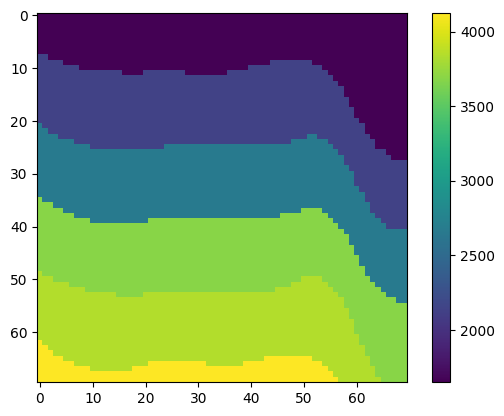

<class 'jaxlib.xla_extension.ArrayImpl'>


In [5]:
model = jnp.load('model1.npy')
print(model.shape)

curvel_single_model = model[84,0,:,:]
plt.imshow(curvel_single_model)
plt.colorbar()
plt.show()
print(type(curvel_single_model))

In [17]:
# Inputs preparation 

# frequencies = jnp.array([40, 70, 100, 150, 200])  # List of frequencies
frequencies = jnp.array([50])


    

src_coords_list, receiver_coords_list = generate_2D_gridded_src_rec_positions(N=(70, 70), num_sources=1, num_receivers=5)
src_coords_list = src_coords_list + 0.1
receiver_coords_list = receiver_coords_list + 0.1


print("src_coords_list shape:", src_coords_list.shape)
# print(src_coords_list)
# print(type(src_coords_list))

print("receiver_coords_list shape:", receiver_coords_list.shape)
# print(receiver_coords_list)
# print(type(receiver_coords_list))

# sound_speed = jnp.ones((70, 70)) * 1500  # Shape: (grid_x, grid_y)


# source from the BD experiement

# sources_BD = jnp.array([[14.382133 ,  2.       ],
#  [ 5.5706286, 35.721813 ],
#  [ 2.     ,   60.984917 ],
#  [17.679596 , 47.96921  ],
#  [28.95357 ,   7.5863786],
#  [30.99244 ,  62.78967  ],
#  [48.796   ,  20.815329 ],
#  [63.72263  ,  7.250306 ],
#  [66.1188   , 29.993034 ],
#  [62.13771 ,  60.35725  ]])

# src_coords_list = sources_BD.astype(jnp.int32)




sound_speed = curvel_single_model


src_coords_list shape: (1, 2)
receiver_coords_list shape: (25, 2)


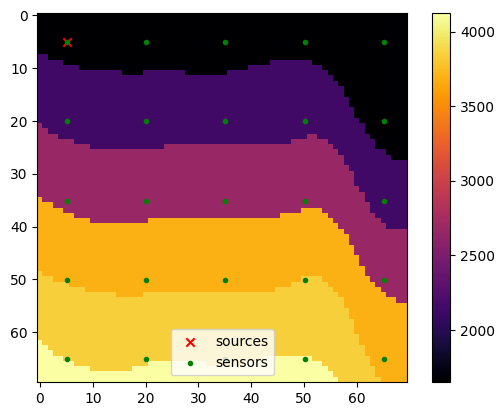

In [18]:
# plot of the velocity model with the sources and receivers and colorbar
plt.imshow(sound_speed, cmap="inferno")
plt.colorbar()
plt.scatter(src_coords_list[:, 0], src_coords_list[:, 1], c="r",
                marker="x",
                label="sources",)
plt.scatter(receiver_coords_list[:, 0], receiver_coords_list[:, 1], c="g",
                marker=".",
                label="sensors",
                )
plt.legend()
plt.show()


### Triple vmap
Only implementation that produes the propoer full jacobian. The function field_at_receiver has to be evaluated for every src and rec pairs which sounds not efficient. However the vjp is only on a single vector backprop instead of a complete identity.

In [ ]:
def compute_jacobian_for_src_and_rec(src_coord, rec_coord, sound_speed, omega):
    def field_at_receiver(sound_speed, src_coord, rec_coord, omega):
        # Solve the Helmholtz equation for a single receiver coordinate
        field = solve_helmholtz_general(sound_speed, src_coord, omega)
        rec_real, rec_imag = extract_receiver_values_interpolated(field, rec_coord[None, :])  # Single receiver
        return rec_real[0], rec_imag[0]  # Extract single receiver values

    # Compute VJP for the given source and receiver
    (y_real, y_imag), vjp_fn = vjp(
        lambda s: field_at_receiver(s, src_coord, rec_coord, omega),
        sound_speed
    )
    
    # Calculate VJP for both real and imaginary parts
    jacobian_real = vjp_fn((jnp.array([1.0]), jnp.array([0.0])))[0]  # Shape: (x,)
    jacobian_imag = vjp_fn((jnp.array([0.0]), jnp.array([1.0])))[0]  # Shape: (x,)
    
    
    return jacobian_real, jacobian_imag  # Shape: (x,)

# Outer `vmap` over frequencies
batched_jacobian_freq_src_rec = jax.vmap(
    lambda omega: jax.vmap(
        lambda src_coords_list: jax.vmap(
            lambda receiver_coords_list: compute_jacobian_for_src_and_rec(src_coords_list, receiver_coords_list, sound_speed, omega),
            in_axes=(0,)  # Batch over receiver coordinates
        )(receiver_coords_list),
        in_axes=(0,)  # Batch over source coordinates
    )(src_coords_list),
    in_axes=(0,)  # Batch over frequencies
)


# print("src_coords:", src_coords.shape, "receiver_coords:", receiver_coords.shape)
# out_r, out_i = batched_compute_jacobian(src_coords_list, sound_speed, receiver_coords_list, 2 * jnp.pi * frequencies)
# print(out_r.shape, out_i.shape)
# rec_coord


jacobians_real, jacobians_imag = batched_jacobian_freq_src_rec(2 * jnp.pi * frequencies)


field shape: (70, 70) receiver_coords shape: (1, 2)


In [9]:
print(src_coords_list.shape, sound_speed.shape, receiver_coords_list.shape)

(1, 2) (70, 70) (4, 2)


In [10]:
jacobians_real.shape, jacobians_imag.shape

((1, 1, 4, 70, 70), (1, 1, 4, 70, 70))

### Double vmap 
Full identity matrix as cotengent for the vjp. Requires only n_sources evaluations of the field _at_receiver function but requires 2 the amount of evaluation during the vjp. Both should be equivalent for a 3x n_sources evaluation to get the full jacobian.

In [ ]:
def compute_jacobian_for_src(src_coord, sound_speed, receiver_coords, omega):
    def field_at_receivers(sound_speed, src_coord, receiver_coords, omega):
        # Solve the Helmholtz equation for the full set of receivers
        field = solve_helmholtz_general(sound_speed, src_coord, omega)
        rec_real, rec_imag = extract_receiver_values_interpolated(field, receiver_coords)
        return rec_real, rec_imag  # Shape: (25,)

    # Compute VJP for the given source coordinate
    (y_real, y_imag), vjp_fn = vjp(
        lambda s: field_at_receivers(s, src_coord, receiver_coords, omega),
        sound_speed
    )
    
    # Calculate VJP for all receivers at once
    n_receivers = receiver_coords.shape[0]
    cotangent_real = (jnp.eye(n_receivers), jnp.zeros((n_receivers, n_receivers)))
    cotangent_imag = (jnp.zeros((n_receivers, n_receivers)), jnp.eye(n_receivers))
    
    jacobian_real = vjp_fn(cotangent_real)[0]  # Shape: (25, x)
    jacobian_imag = vjp_fn(cotangent_imag)[0]  # Shape: (25, x)
    
    return jacobian_real, jacobian_imag  # Shape: (25, x)

# Vectorized computation over frequencies and sources
batched_jacobian = jax.vmap(
    lambda omega: jax.vmap(
        lambda src_coord: compute_jacobian_for_src(src_coord, sound_speed, receiver_coords_list, omega),
        in_axes=(0,)  # Batch over source coordinates
    )(src_coords_list),
    in_axes=(0,)  # Batch over frequencies
)
jacobians_real, jacobians_imag = batched_jacobian(2 * jnp.pi * frequencies)

field shape: (70, 70) receiver_coords shape: (25, 2)


In [ ]:
def compute_jacobian_for_src(src_coord, sound_speed, receiver_coords, omega):
    def field_at_receivers(sound_speed, src_coord, receiver_coords, omega):
        # Solve the Helmholtz equation for the full set of receivers
        field = solve_helmholtz_general(sound_speed, src_coord, omega)
        rec_real, rec_imag = extract_receiver_values_interpolated(field, receiver_coords)
        return rec_real, rec_imag  # Shape: (25,)

    # Compute VJP for the given source coordinate
    (y_real, y_imag), vjp_fn = vjp(
        lambda s: field_at_receivers(s, src_coord, receiver_coords, omega),
        sound_speed
    )
    
    # Calculate VJP for all receivers at once
    n_receivers = receiver_coords.shape[0]
    cotangent_real = (jnp.eye(n_receivers), jnp.zeros((n_receivers, n_receivers)))
    cotangent_imag = (jnp.zeros((n_receivers, n_receivers)), jnp.eye(n_receivers))
    
    jacobian_real = vjp_fn(cotangent_real)[0]  # Shape: (25, x)
    jacobian_imag = vjp_fn(cotangent_imag)[0]  # Shape: (25, x)
    
    return jacobian_real, jacobian_imag  # Shape: (25, x)

# Vectorized computation over frequencies and sources
batched_jacobian = jax.vmap(
    lambda omega: jax.vmap(
        lambda src_coord: compute_jacobian_for_src(src_coord, sound_speed, receiver_coords_list, omega),
        in_axes=(0,)  # Batch over source coordinates
    )(src_coords_list),
    in_axes=(0,)  # Batch over frequencies
)
jacobians_real, jacobians_imag = batched_jacobian(2 * jnp.pi * frequencies)


field shape: (70, 70) receiver_coords shape: (25, 2)


### Reshape the full jacobian to fit with plotting routines

In [11]:
jacobians_combined = jnp.concatenate([jacobians_real, jacobians_imag], axis=-1)


In [12]:
jacobians_combined.shape

(1, 1, 4, 70, 140)

In [13]:
jacobians_combined_srf= jnp.transpose(jacobians_combined, axes=(1, 2, 0, 3, 4))
# add an axis to the jacobians_combined
# jacobians_combined = jnp.expand_dims(jacobians_combined, axis=1)

In [14]:
print(jacobians_combined.shape)
print(jacobians_combined_srf.shape)


(1, 1, 4, 70, 140)
(1, 4, 1, 70, 140)


In [15]:
def plot_specific_jacobian(jacobians, frequencies, src_coords, rec_coords, 
                           source_idx=None, receiver_idx=None, frequency_idx=None, save_path=None):
    """
    Plot the real and imaginary parts of a specific Jacobian from a structured array.

    Parameters:
        jacobians (array): Array of shape (n_sources, n_receivers, n_frequencies, rows, cols).
        frequencies (list): List of frequencies corresponding to the third dimension of `jacobians`.
        src_coords (list): List of source coordinates.
        rec_coords (array): Array of receiver coordinates.
        source_idx (int, optional): Index of the source to plot.
        receiver_idx (int, optional): Index of the receiver to plot.
        frequency_idx (int, optional): Index of the frequency to plot.
        save_path (str, optional): Path to save the plots. If None, displays them instead.
    """
    if source_idx is None or receiver_idx is None or frequency_idx is None:
        raise ValueError("You must specify source_idx, receiver_idx, and frequency_idx.")

    # Extract real and imaginary parts
    real_part = jacobians[source_idx, receiver_idx, frequency_idx, :].reshape(70,140)[:,:70]
    imaginary_part = jacobians[source_idx, receiver_idx, frequency_idx, :].reshape(70,140)[:,70:]

    # Plot real part
    plt.figure(figsize=(10, 8))
    plt.imshow(real_part, aspect='auto', cmap='viridis')
    plt.colorbar(label="Magnitude")
    title_real = (
        f"Jacobian Real Part\n"
        f"Frequency: {frequencies[frequency_idx]} Hz, "
        f"Source: {src_coords[source_idx][0]}, "
        f"Receiver: {rec_coords[receiver_idx]}"
    )
    plt.title(title_real)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()

    # Overlay source and receiver markers
    if src_coords is not None and rec_coords is not None:
        plt.scatter(src_coords[source_idx][1], src_coords[source_idx][0], marker='*', c='red', s=100)
        plt.scatter(rec_coords[receiver_idx, 1], rec_coords[receiver_idx, 0], marker='^', c='blue', s=100)

    # Save or show real part
    if save_path:
        filename_real = f"{save_path}/jacobian_real_f{frequency_idx}_s{source_idx}_r{receiver_idx}.png"
        plt.savefig(filename_real, dpi=300)
    else:
        plt.show()

    # Plot imaginary part
    plt.figure(figsize=(10, 8))
    plt.imshow(imaginary_part, aspect='auto', cmap='viridis')
    plt.colorbar(label="Magnitude")
    title_imag = (
        f"Jacobian Imaginary Part\n"
        f"Frequency: {frequencies[frequency_idx]} Hz, "
        f"Source: {src_coords[source_idx][0]}, "
        f"Receiver: {rec_coords[receiver_idx]}"
    )
    plt.title(title_imag)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()

    # Overlay source and receiver markers
    if src_coords is not None and rec_coords is not None:
        plt.scatter(src_coords[source_idx][1], src_coords[source_idx][0], marker='*', c='red', s=100)
        plt.scatter(rec_coords[receiver_idx, 1], rec_coords[receiver_idx, 0], marker='^', c='blue', s=100)

    # Save or show imaginary part
    if save_path:
        filename_imag = f"{save_path}/jacobian_imag_f{frequency_idx}_s{source_idx}_r{receiver_idx}.png"
        plt.savefig(filename_imag, dpi=300)
    else:
        plt.show()

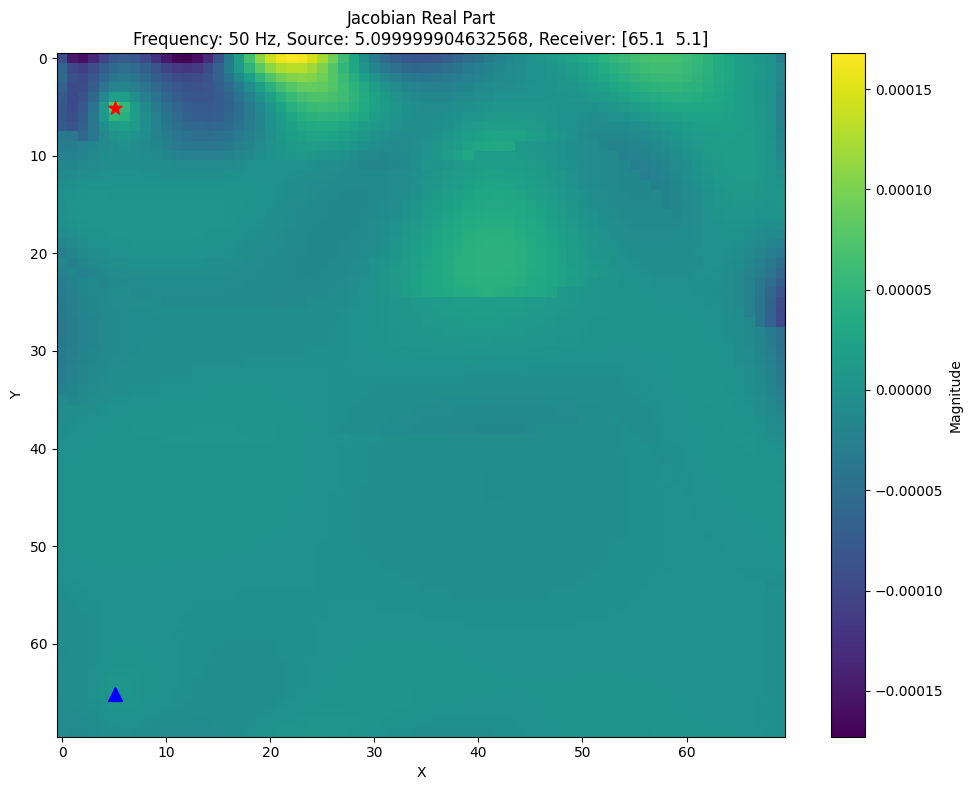

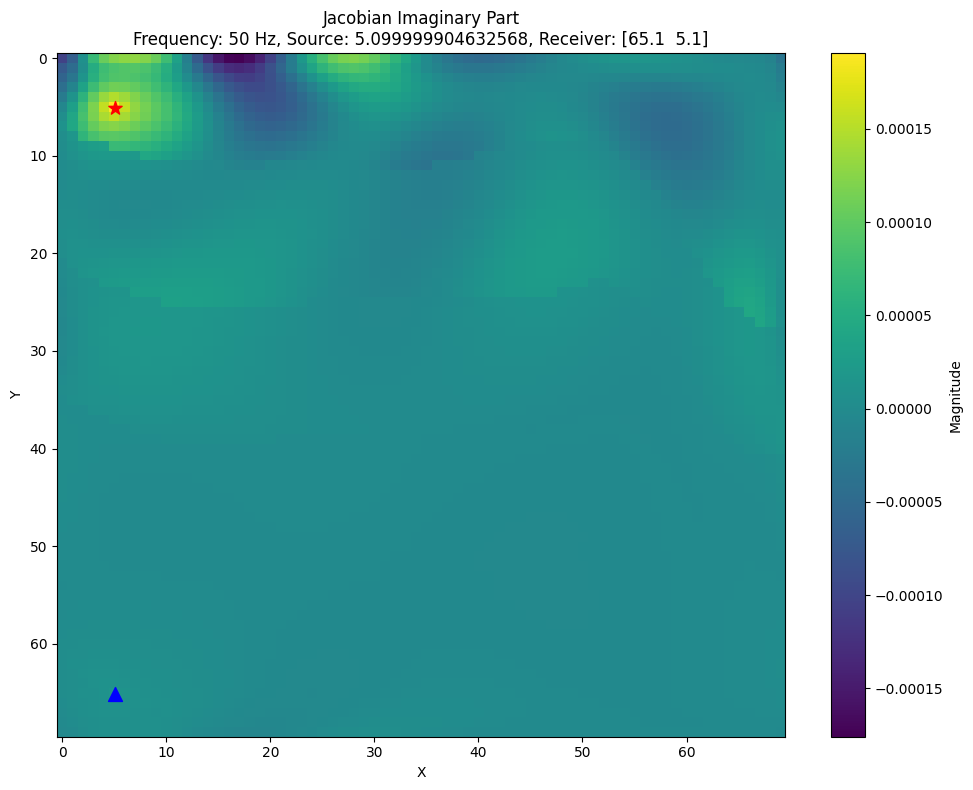

In [16]:
plot_specific_jacobian(jacobians_combined_srf,frequencies, src_coords_list, receiver_coords_list, source_idx=4, receiver_idx=2, frequency_idx=2, save_path=None)

### Save the jacobian to a npy file

In [ ]:
# save the JAcobian to an npy file
jnp.save("curvel_jac_model_84_data_test_case_BD.npy", jacobians_combined_srf)